# Leaspy model for comparison

In [1]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
# import leaspy

path_leaspy = '/home/benoit.sautydechalon/leaspy/'
sys.path.append(path_leaspy)

from leaspy import Leaspy, Data, IndividualParameters, AlgorithmSettings

### MDS

In [34]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data.index.set_names(['ID','TIME'], inplace=True)
data

NameError: name 'mds1' is not defined

## ADNI data

In [240]:
path = '../adni_study'
data = '/data_adni'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
hip = [score[0] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
adas = [score[2] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [241]:
data = pd.DataFrame(index=[ids, times], columns=['ven', 'adas'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

ven      adas       hip
ID   TIME                                
21   77.640  0.292681  0.096012  0.377238
     78.647  0.348860  0.162012  0.412620
     79.630  0.332652  0.036000  0.380280
     80.649  0.324140  0.167988  0.439737
     82.694  0.365129  0.162012  0.431896
...               ...       ...       ...
5290 67.079  0.092811  0.203988  0.368073
     69.128  0.159048  0.138000  0.340166
     71.074  0.217518  0.126012  0.260959
     72.211  0.198040  0.111000  0.343376
     73.068  0.215177  0.060012  0.332413

[2673 rows x 3 columns]

## tadpole data

In [13]:
path = '../tadpole'
data = '/data'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
hip = [score[2] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
adas = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [14]:
data = pd.DataFrame(index=[ids, times], columns=['ven', 'adas'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

ven    adas       hip
ID   TIME                            
3    81.3  0.734103  0.6200  0.653835
     81.8  0.774397  0.6000  0.642919
     82.3  0.788756  0.7000  0.661404
     83.3  0.853026  0.7534  0.662515
4    67.5  0.393038  0.4266  0.488743
...             ...     ...       ...
5082 71.2  0.382486  0.0600  0.380519
5093 69.3  0.232973  0.1000  0.429994
     69.8  0.227302  0.0200  0.425069
     70.3  0.231179  0.0600  0.423033
     71.3  0.241855  0.1200  0.404683

[3739 rows x 3 columns]

## bivariate data

In [179]:
path = '../bivariate_study'
data = '/bivariate_data'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
hip = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
adas = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [180]:
data = pd.DataFrame(index=[ids, times], columns=['hip', 'adas'])
data['hip'] = hip
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

hip      adas
ID   TIME                    
4    67.5  0.407333  0.377389
     68.0  0.518444  0.375055
     68.5  0.466667  0.364087
     69.0  0.540667  0.382969
     70.5  0.511111  0.429288
...             ...       ...
1425 77.6  0.540667  0.242699
     78.6  0.607333  0.267690
1430 83.4  0.577778  0.745385
     83.9  0.659333  0.774981
     85.4  0.770444  0.804698

[942 rows x 2 columns]

### Simulated data

In [146]:
path = '../simulated_study'
data = '/simulated_data_1'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [147]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data.index.set_names(['ID','TIME'], inplace=True)
data

logistic  sum_logistic
ID  TIME                             
0   55.764067  0.423630      0.464063
    56.264067  0.440336      0.495255
    56.764067  0.447971      0.458690
    57.264067  0.494731      0.481166
    57.764067  0.502920      0.452465
...                 ...           ...
299 67.810785  0.587139      0.691150
    68.310785  0.549751      0.697607
    68.810785  0.570529      0.693200
    69.310785  0.577374      0.736736
    69.810785  0.578576      0.746236

[2400 rows x 2 columns]

### Pruned data

In [20]:
path = '../simulated_study'
path_data = '/simulated_data_3'

times = [time[0] for time in pd.read_csv(path+path_data+'/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+path_data+'/Y_pruned.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+path_data+'/Y_pruned.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+path_data+'/group.csv', header=None).values]

In [21]:
data_pruned = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data_pruned['logistic'] = logistic
data_pruned['sum_logistic'] = sum_logistic
data_pruned.index.set_names(['ID','TIME'], inplace=True)
data_pruned

logistic  sum_logistic
ID  TIME                             
0   56.340559       NaN           NaN
    56.840559       NaN           NaN
    57.340559  0.252891      0.440507
    57.840559       NaN           NaN
    58.340559  0.261381      0.477437
...                 ...           ...
199 72.828851       NaN           NaN
    73.328851  0.694015      0.922010
    73.828851  0.699477      0.911478
    74.328851  0.686855      0.922275
    74.828851       NaN           NaN

[2000 rows x 2 columns]

## Leaspy model

In [12]:
n_iter = 1000
n_sources = 1

settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter, progress_bar=True)
settings.set_logs(path='logs_small_model',  plot_periodicity=50,save_periodicity=10,
                           console_print_periodicity=None,overwrite_logs_folder=True) 
# Fitting the model

ip_list = []
model_parameters_list = []

for i in range(1):

    leaspy = Leaspy('logistic')
    leaspy.model.load_hyperparameters({'source_dimension': n_sources})

    data_leaspy = Data.from_dataframe(data)

    leaspy.fit(data_leaspy, settings)
    print(leaspy.model.parameters)
    settings_2 = AlgorithmSettings('mode_real', n_jobs=2, use_jacobian=True)

    #data_leaspy = Data.from_dataframe(data_pruned)
    individual_parameters = leaspy.personalize(data_leaspy, settings_2)
    individual_parameters.to_dataframe().to_csv('joint_study_small_param.csv')
    
    model_parameters_list.append(leaspy.model.parameters)
    ip_list.append(individual_parameters)


...overwrite logs folder...
|##################################################|   1000/1000 iterations
The standard deviation of the noise at the end of the calibration is:
0.0558

Calibration took: 1min 50s
{'g': tensor([0.5569, 1.2274, 0.3048]), 'v0': tensor([-4.0882, -4.2515, -4.6836]), 'betas': tensor([[0.1354],
        [0.0802]]), 'tau_mean': tensor(73.8490), 'tau_std': tensor(8.3614), 'xi_mean': tensor(0.), 'xi_std': tensor(0.7666), 'sources_mean': tensor(0.), 'sources_std': tensor(1.), 'noise_std': tensor(0.0558)}

The standard deviation of the noise at the end of the personalization is:
0.0514

Personalization mode_real took: 11s


In [228]:
settings_2 = AlgorithmSettings('mode_real', n_jobs=2, use_jacobian=True)

#data_leaspy = Data.from_dataframe(data_pruned)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
individual_parameters.to_dataframe().to_csv('joint_study_small_param.csv')


The standard deviation of the noise at the end of the personalization is:
0.0874

Personalization mode_real took: 9s


In [15]:
data['TIME'] = data.index.get_level_values(1)
data['ID'] = data.index.get_level_values(0)
data = data.set_index('ID')

In [16]:
individual_parameters = pd.read_csv('joint_study_small_param.csv').set_index('ID')
individual_parameters.index = data.index.unique()
individual_parameters

,tau,xi,sources
ID,,,
3,72.176407,0.907824,0.124824
4,61.608582,0.231355,-0.812065
5,71.517456,-0.287127,-0.216451
6,71.519394,0.118434,-0.645144
10,70.607117,0.861019,-1.267756
...,...,...,...
4989,72.950394,-0.128816,-0.629387
5066,71.940689,-0.380864,0.254518
5079,78.183273,0.038219,0.065309


In [17]:
individual_parameters.describe()

,tau,xi,sources
count,735.000000,735.000000,735.000000
mean,73.892491,0.219071,-0.106522
std,7.000790,0.598119,0.925436
min,40.067062,-2.034816,-6.437037
25%,69.619774,-0.172448,-0.711603
50%,74.180733,0.118434,-0.147844
75%,78.234745,0.499678,0.448617
max,96.045998,2.065904,2.803463


In [18]:
from utils import predict_scores

predicted_scores = predict_scores(data, individual_parameters, leaspy)
abs(predicted_scores - data).describe()

,TIME,adas,hip,ven
count,3739.0,3739.000000,3739.000000,3.739000e+03
mean,0.0,0.047204,0.046830,1.983492e-02
std,0.0,0.037238,0.037946,1.734383e-02
min,0.0,0.000032,0.000033,7.270262e-07
25%,0.0,0.018187,0.018052,7.249360e-03
50%,0.0,0.038924,0.038191,1.585194e-02
75%,0.0,0.067428,0.065421,2.767089e-02
max,0.0,0.296001,0.241228,1.469618e-01


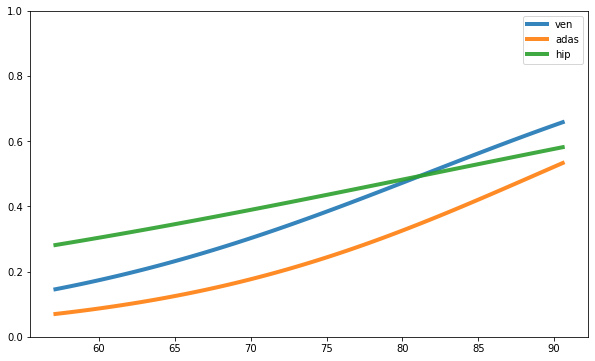

In [19]:
model = leaspy.model

labels = model.features
fig, ax = plt.subplots(figsize=(10, 6))

cmap = matplotlib.cm.get_cmap('viridis_r')
colors = [cmap(11*i) for i in range(121)]

mean_time = model.parameters['tau_mean']
std_time = max(model.parameters['tau_std'], 4)
timepoints = np.linspace(mean_time - 2* std_time, mean_time + 2* std_time, 100)
timepoints = torch.Tensor([timepoints])

mean_trajectory = model.compute_mean_traj(timepoints).detach().numpy()

for i in range(len(labels)):
    ax.plot(timepoints[0, :].detach().numpy(), mean_trajectory[0, :, i], label=labels[i],
            linewidth=4, alpha=0.9)  # , c=colors[i])
    
ax.legend()

plt.ylim((0,1))
plt.show()

## Visualization of distribution of diagnosis vs (tau/xi)

In [222]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [231]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


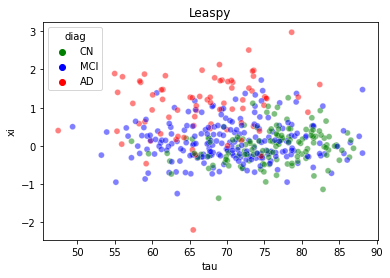

In [232]:
%matplotlib inline

sub_diag = sub_diag.loc[individual_parameters.index]
individual_parameters['diag'] = sub_diag['diag']
individual_parameters['label'] = sub_diag['label']

sns.scatterplot(data = individual_parameters,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'])
plt.title('Leaspy')
plt.show()

In [233]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

colors = ['green', 'blue', 'red']
data = individual_parameters

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.2)
        ax.add_artist(ell)


X, y = data[['tau', 'xi']].values, data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [234]:
from sklearn.model_selection import KFold

train_total, test_total = 0, 0

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
print(kf)

y = np.array(y)

for train_index, test_index in kf.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    n_classes = len(np.unique(y_train))

    estimator = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=100, random_state=0)
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    train_total += train_accuracy

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    test_total += test_accuracy

print(train_total/5, test_total/5)

KFold(n_splits=5, random_state=None, shuffle=True)
54.94186046511628 53.72093023255813


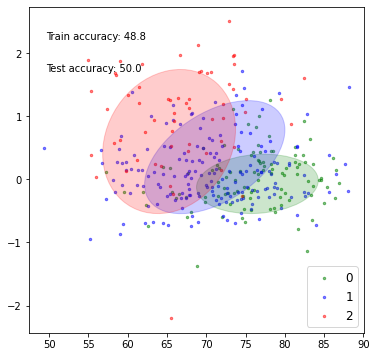

In [235]:
estimator = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=200, random_state=0)

estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

# Train the other parameters using the EM algorithm.
estimator.fit(X_train)

plt.figure(figsize=(3 * n_estimators // 2, 6))
h = plt.subplot(111)
make_ellipses(estimator, h)

for n, color in enumerate(colors):
    data = X_train[y_train == n]
    plt.scatter(data[:, 0], data[:, 1], s=6, alpha=0.5, color=color,label=n)

y_train_pred = estimator.predict(X_train)
train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
         transform=h.transAxes)

y_test_pred = estimator.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
         transform=h.transAxes)


plt.xticks()
plt.yticks()

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

<AxesSubplot:>

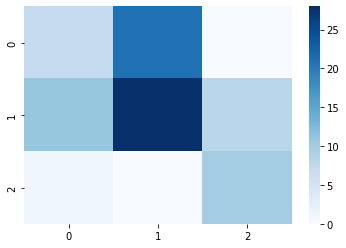

In [123]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.ravel(), y_test_pred.ravel(), labels=[0, 1, 2])  
sns.heatmap(cm, cmap=plt.cm.Blues)

<AxesSubplot:xlabel='tau', ylabel='xi'>

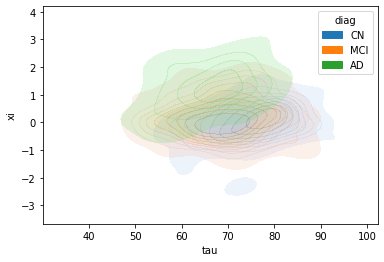

In [49]:
sns.kdeplot(data=individual_parameters, x='tau', y='xi', hue='diag', fill=True, alpha=0.2)

In [13]:
true_individual_parameters = pd.read_csv(path+'/simulated_data_1/true_individual_parameters.csv').set_index('Unnamed: 0')
true_individual_parameters.index.name = 'ID'
true_individual_parameters

,xi,tau,source
ID,,,
0,-0.042195,65.204252,14.855125
1,0.277844,72.614263,-4.664902
2,-0.448266,62.417224,11.654640
3,0.687274,78.584107,10.606578
4,0.474100,88.115856,-4.351091
...,...,...,...
295,-0.266133,89.821899,-14.452402
296,0.578161,85.970123,-4.993718
297,0.419483,77.756186,-1.596787


In [29]:
abs(true_individual_parameters - individual_parameters).describe()

,source,sources,tau,xi
count,0.0,0.0,300.000000,300.000000
mean,NaN,NaN,16.290012,0.503500
std,NaN,NaN,11.039638,0.390073
min,NaN,NaN,0.214407,0.000187
25%,NaN,NaN,7.583963,0.216354
50%,NaN,NaN,14.494875,0.396142
75%,NaN,NaN,22.746722,0.751932
max,NaN,NaN,52.247168,1.787517
